In [1]:
import pandas as pd
import numpy as np
import math
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
filename = "sap_storing_data_hu_project.csv" 
df_not_cleaned = pd.read_csv(filename, low_memory=False)
#verwijder alle kolommen die niet van gebruik zijn:
df = df_not_cleaned.drop(columns=['stm_sap_mon_meld_ddt', 'stm_mon_begin_ddt', 'stm_mon_toelichting_trdl', 'stm_oh_pg_mld', 'stm_geo_mld_uit_functiepl', 'stm_scenario_mon', 'stm_status_melding_sap', 'stm_mon_nr_status_omschr', 'stm_mon_nr__statuscode', 'stm_mon_nr_status_wijzdd', 'stm_aanntpl_ddt', 'stm_geo_gst_uit_functiepl', 'stm_objectdl_code_gst', 'stm_objectdl_groep_gst', 'stm_progfh_in_ddt', 'stm_progfh_in_invoer_ddt', 'stm_progfh_gw_ddt', 'stm_progfh_gw_lwd_ddt', 'stm_progfh_hz', 'stm_veroorz_groep', 'stm_veroorz_code', 'stm_progfh_gw_duur', 'stm_progfh_gw_lwd_tijd', 'stm_progfh_gw_lwd_datum', 'stm_progfh_gw_datum', 'stm_arbeid', 'stm_functiepl_gst', 'stm_functiepl_mld', 'stm_mon_begintijd', 'stm_mon_begindatum', 'stm_aangelegd_tijd', 'stm_aangelegd_dd', 'stm_dir_betrok_tr', 'stm_evb', 'stm_mon_vhdsincident', 'stm_mon_eind_ddt', 'stm_afspr_aanvangddt', 'stm_effect', 'stm_veroorz_tekst_kort', 'stm_projnr', 'stm_wbi_nummer', 'stm_status_gebr', 'stm_standplaats', 'stm_actie', 'stm_hinderwaarde', 'stm_rec_toegev_ddt', 'stm_afsluit_tijd', 'stm_afsluit_dd', 'stm_afsluit_ddt', 'stm_akkoord_melding_jn', 'stm_fact_jn', 'stm_status_sapnaarmon', 'stm_akkoord_mon_toewijz', 'stm_controle_dd', 'stm_mon_eind_tijd', 'stm_mon_eind_datum', 'stm_reactie_duur', 'stm_afspr_aanvangtijd', 'stm_afspr_aanvangdd', 'stm_historie_toelichting', 'stm_schade_verhaalb_jn', 'stm_x_bron_arch_dt', 'stm_x_bron_bestandsnaam', 'stm_x_bron_publ_dt', 'stm_rapportage_jaar', 'stm_rapportage_maand', 'stm_sorteerveld', 'stm_afspr_func_hersteltijd', 'stm_afspr_func_hersteldd', 'stm_relatiervo', 'stm_relatiervo_volgend', 'stm_relatiervo_vorig', 'stm_schade_statusdatum', 'stm_schade_status_ga', 'stm_schadenr', 'stm_x_start_sessie_dt', 'stm_x_bk', 'stm_x_run_id', 'stm_x_actueel_ind', 'stm_x_vervallen_ind'])
print("Done")

Done


# Data cleaning:


De te bepalen welke variabelen het meest van toepassing zijn om te gebruiken kijken we naar welke
kolommen informatie geven over de tijd van de melding, monteur. Tijd wanneer de melding word opgelost.
Wat voor melding het is en info over de melding/storing, en de locatie. Zo zijn de volgende kolommen
het meest van toepassing:

Over soort melding
- stm_sap_meldtekst (melding omschrijving)
- stm_geo_mld (melding code) - nodig
- stm_oorz_code (oorzaak code) - nodig
- stm_prioriteit (prioriteit)

Over tijd:
- stm_sap_melddatum (datump melding) - nodig
- stm_sap_meldtijd (tijdstip melding) - nodig
- stm_aanngeb_dd (datum aannemer gebeld)
- stm_aanngeb_tijd (tijd aannemer gebeld)
- stm_aanntpl_dd (datum aannemer op plek)
- stm_aanntpl_tijd (tijd aannemer op plek)

- stm_fh_dd (Datum van functie herstel) - nodig
- stm_fh_tijd (Tijdstip van functieherstel) - nodig
- stm_sap_storeinddatum (Datum einde storing) - nodig
- stm_sap_storeindtijd (Tijdstip einde storing) - nodig
- stm_fh_duur (Duur van functiehersteltijd) - nodig

Over equipment:
- stm_equipm_nr_mld (equipment)
- stm_equipm_omschr_mld (equipment omschrijving)

Over locatie
- stm_km_van_mld (locatie van)
- stm_km_tot_mld (locatie tot)
- stm_vl_post (VL post) - nodig
- stm_contractgeb_mld(locatie melding) - nodig
- stm_pplg_van (PPLG van locatie)
- stm_pplg_naar (PPLG tot locatie)
- stm_dstrglp_van (Dienstregelpunt van locatie)
- stm_dstrglp_naar (Dienstregelpunt tot locatie)

Over prognose:
- stm_progfh_in_datum (Datum prognose)
- stm_progfh_in_tijd (Tijdstip FHT prognose)
- stm_progfh_in_invoer_dat (Invoer datum prognose)
- stm_progfh_in_invoer_tijd (Invoer tijdstip FHT prognose)
- stm_progfh_in_duur (Duur FHT)



In [3]:
#deze functie verwijdert alle rijen waar geen value op de gegeven kolommen zitten
def drop_rows_with_null(lst, df):
    dfisnull = df.isnull()[lst]
    matches = dfisnull[(dfisnull).any(axis=1)]
    return df.drop(matches.index)

In [4]:
#Deze functie berkent de uitschiet grenzen
def uitschieters_bereken(kolom):
    q1 = kolom.quantile(0.25)
    q3 = kolom.quantile(0.75)
    iqr = q3 - q1
    maxuitschieter = q3 + (iqr*1.5)
    minuitschieter = q1 - (iqr*1.5)
    return maxuitschieter, minuitschieter

#Deze functie geeft de indexes van uitschieters in een kolom
def return_uitschieters_indexes(kolom):
    maxuitschieter = uitschieters_bereken(kolom)[0]
    minuitschieter = uitschieters_bereken(kolom)[1]
    uitschieters = [kolom[kolom > maxuitschieter].index, kolom[kolom < minuitschieter].index]
    return uitschieters
    
#Deze functie geeft een kolom zonder uitschieters
def return_kolom_zonder_uitschieters(kolom):
    maxuitschieter = uitschieters_bereken(kolom)[0]
    minuitschieter = uitschieters_bereken(kolom)[1]
    kolom = kolom[kolom < maxuitschieter][kolom > minuitschieter]
    return kolom


In [5]:
#Deze functie berkent de extreme uitschiet grenzen
def ex_uitschieters_bereken(kolom):
    q1 = kolom.quantile(0.25)
    q3 = kolom.quantile(0.75)
    iqr = q3 - q1
    maxuitschieter = q3 + (iqr*3)
    minuitschieter = q1 - (iqr*3)
    return maxuitschieter, minuitschieter

#Deze functie geeft de indexes van extreme uitschieters in een kolom
def return_ex_uitschieters_indexes(kolom):
    maxuitschieter = uitschieters_ex_bereken(kolom)[0]
    minuitschieter = uitschieters_ex_bereken(kolom)[1]
    uitschieters = [kolom[kolom > maxuitschieter].index, kolom[kolom < minuitschieter].index]
    return uitschieters
    
#Deze functie geeft een kolom zonder extreme uitschieters
def return_kolom_zonder_ex_uitschieters(kolom):
    maxuitschieter = uitschieters_ex_bereken(kolom)[0]
    minuitschieter = uitschieters_ex_bereken(kolom)[1]
    kolom = kolom[kolom < maxuitschieter][kolom > minuitschieter]
    return kolom

In [6]:
# Verwijder de rijen die geen value bevatten in de benodigde kolommen
df_filtered = drop_rows_with_null(['stm_geo_mld', 'stm_sap_melddatum', 'stm_oorz_code', 'stm_sap_meldtijd',
                          'stm_fh_dd', 'stm_fh_tijd', 'stm_sap_storeinddatum', 'stm_sap_storeindtijd',
                          'stm_fh_duur', 'stm_vl_post', 'stm_contractgeb_mld'], df)
df_filtered = (df_filtered.loc[(df_filtered['stm_fh_duur'] > 5) & (df_filtered['stm_fh_duur'] < 360)])
df_filtered = (df_filtered[(df_filtered['stm_km_van_mld'] < 500)])
# hoger dan 5 minuten,als het onder de 5 minuten zit is er een goede kans dat het een fout was.
print(len(df))
print(len(df_filtered))
df_filtered

898526
27559


,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_meldtekst_lang,stm_sap_meldtekst,stm_geo_mld,stm_equipm_nr_mld,stm_equipm_soort_mld,...,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar
85,87,50053389,37.0,EHV,10/01/2006 16:11:00,Logboeknr RBV : 37 Tijd: 1611 VL-Post: ...,Logboeknr RBV : 37 Tijd: 1611 VL-P,618.0,10646141.0,SYSTBOVENL,...,10/01/2006,16:31:00,20.0,11/01/2006,10:33:00,Geen SMC-melding. Afwijzing. Bij het SMC,NaN,NaN,EHV,NaN
123,125,50053438,62.0,AH,15/01/2006 23:08:00,Logboeknr RBV : 62 Tijd: 2308 VL-Post: ...,Logboeknr RBV : 62 Tijd: 2308 VL-P,514.0,10201441.0,WISSEL,...,15/01/2006,23:20:00,12.0,15/01/2006,23:20:00,NaN,NaN,NaN,Nm,NaN
205,208,50053591,39.0,EHV,20/01/2006 14:32:00,Logboeknr RBV : 39 Tijd: 1432 VL-Post: ...,Logboeknr RBV : 39 Tijd: 1432 VL-P,515.0,10527838.0,WISSEL,...,20/01/2006,14:47:00,15.0,23/01/2006,11:39:00,Geen SMC-melding.,NaN,NaN,Vga,NaN
226,229,50053628,250.0,ZL,24/01/2006 20:20:00,Logboeknr RBV : 250 Tijd: 2020 VL-Post: ...,Logboeknr RBV : 250 Tijd: 2020 VL-P,25.0,10211614.0,OVERWEG,...,24/01/2006,20:30:00,10.0,24/01/2006,20:30:00,NaN,NaN,NaN,AMRI,NaN
240,243,50053652,42.0,RSD,25/01/2006 09:30:00,Logboeknr RBV : 42 Tijd: 0930 VL-Post: ...,Logboeknr RBV : 42 Tijd: 0930 VL-P,127.0,10621371.0,DETECTREIN,...,25/01/2006,09:44:00,14.0,30/01/2006,11:21:00,Geen SMC-melding.Geen onderzoek geweest.,NaN,NaN,Arn,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898208,908312,99003083,977890.0,RTD,25/10/2010 13:31:00,Ddrs-Sdt : ATB terugval voor Baanhoekbrug.,Ddrs-Sdt : ATB terugval voor Baanhoekbru,118.0,10056913.0,TREINBEINV,...,25/10/2010,14:15:00,43.0,27/10/2010,16:00:00,NaN,SDT,NaN,SDT,BMBR
898410,908514,99003207,3669429.0,MT,21/05/2016 13:17:56,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle ovw'en...,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle o,71.0,10621358.0,DETECTREIN,...,21/05/2016,14:35:00,175.0,21/05/2016,14:50:00,Gestoord object: SECTIE 913AT. Gestoord,MTR,NaN,MTR,EDN
898411,908515,99003207,3669429.0,MT,21/05/2016 13:17:56,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle ovw'en...,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle o,71.0,10621358.0,DETECTREIN,...,21/05/2016,14:35:00,175.0,21/05/2016,14:50:00,Gestoord object: SECTIE 913AT. Gestoord,MTR,NaN,MTR,EDN
898412,908516,99003207,3669429.0,MT,21/05/2016 13:17:56,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle ovw'en ...,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle o,71.0,10621358.0,DETECTREIN,...,21/05/2016,14:35:00,175.0,21/05/2016,14:50:00,Gestoord object: SECTIE 913AT. Gestoord,MTR,NaN,MTR,EDN


In [7]:
#uitgeschreven lijsten zodat ik ze niet steeds hoef over te typen

# melding
#df[['stm_sap_meldtekst', 'stm_geo_mld', 'stm_oorz_code', 'stm_prioriteit']]
# tijd
#df[['stm_sap_melddatum', 'stm_sap_meldtijd', 'stm_aanngeb_dd', 'stm_aanngeb_tijd', 'stm_aanntpl_dd', 'stm_aanntpl_tijd']]
#df[['stm_fh_dd', 'stm_fh_tijd', 'stm_fh_duur', 'stm_sap_storeinddatum', 'stm_sap_storeindtijd']]
# equipment
#df[['stm_equipm_omschr_mld', 'stm_equipm_nr_mld']]
# locatie
#df[['stm_km_van_mld', 'stm_km_tot_mld', 'stm_vl_post', 'stm_contractgeb_mld', 'stm_pplg_van', 'stm_pplg_naar', 'stm_dstrglp_van', 'stm_dstrglp_naar']]
# prognose
#df[['stm_progfh_in_datum', 'stm_progfh_in_tijd', 'stm_progfh_in_invoer_dat', 'stm_progfh_in_invoer_tijd', 'stm_progfh_in_duur']]


In [8]:
# minuut van de dag dat de aannemer ter plekken is gekomen lijst gemaakt en in dataset gezet.
df_filtered['stm_aanntpl_tijd'] = df_filtered['stm_aanntpl_tijd'].apply(pd.to_datetime)
df_hour = pd.DataFrame(df_filtered['stm_aanntpl_tijd'].dt.hour)
df_filtered.insert(0, 'Uur_herstel', df_hour)
df_min = pd.DataFrame(df_filtered['stm_aanntpl_tijd'].dt.minute)
df_filtered.insert(1, 'Min_van_uur_herstel', df_min)
df_min_of_day_herstel = (df_filtered['Uur_herstel'] * 60) + df_filtered['Min_van_uur_herstel']
df_filtered.insert(2, 'Minuut_van_dag_herstel', df_min_of_day_herstel)

In [9]:
# minuut van de dag dat de aannemer klaar is lijst gemaakt en in dataset gezet.
df_filtered['stm_fh_ddt'] = df_filtered['stm_fh_ddt'].apply(pd.to_datetime)
df_hour2 = pd.DataFrame(df_filtered['stm_fh_ddt'].dt.hour)
df_filtered.insert(3, 'Uur_hersteld', df_hour2)
df_min2 = pd.DataFrame(df_filtered['stm_fh_ddt'].dt.minute)
df_filtered.insert(4, 'Min_van_uur_hersteld', df_min2)
df_min_of_day_herstel2 = (df_filtered['Uur_hersteld'] * 60) + df_filtered['Min_van_uur_hersteld']
df_filtered.insert(5, 'Minuut_van_dag_hersteld', df_min_of_day_herstel2)

In [10]:
Echte_herstel_tijd = df_filtered['Minuut_van_dag_hersteld'] - df_filtered['Minuut_van_dag_herstel']
Echte_herstel_tijd

85         991
123       1400
205        887
226       1230
240        584
          ... 
898208      15
898410      40
898411      40
898412      40
898413      40
Length: 27559, dtype: int64

# Baseline
Target variabele is 'stm_fh_duur'. Dit is de functie hersteltijd dit houd in dat vanaf de melding tot dat het probleem opgelost is getimed wordt. 

baseline:  

In [11]:
# De target variabele filteren tussen de 0 min en 360 min. Prodcut ower gaf dit als grens aan. 
data_fht = df_filtered['stm_fh_duur'].loc[(df_filtered['stm_fh_duur'] > 0) & (df_filtered['stm_fh_duur'] < 360)]
data_fht

85         20.0
123        12.0
205        15.0
226        10.0
240        14.0
          ...  
898208     43.0
898410    175.0
898411    175.0
898412    175.0
898413    175.0
Name: stm_fh_duur, Length: 27559, dtype: float64

In [12]:
data_fht.describe()

count    27559.000000
mean       106.831235
std         74.858475
min          6.000000
25%         53.000000
50%         88.000000
75%        141.000000
max        359.000000
Name: stm_fh_duur, dtype: float64

In [13]:
data_fht.mean()

106.83123480532676

In [14]:
data_fht.median()

88.0

<AxesSubplot:>

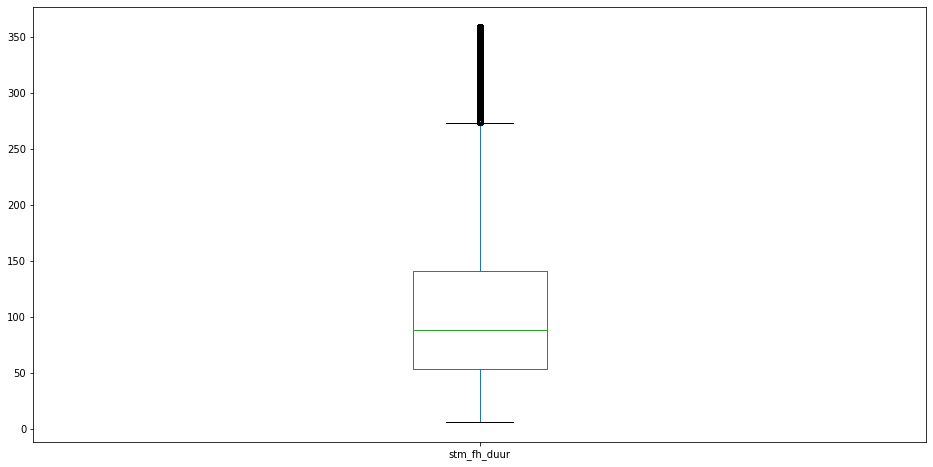

In [15]:
data_fht.plot.box(figsize=(16,8))

In [16]:
len(data_fht[data_fht < data_fht.mean()])

16719

In [17]:
len(data_fht[data_fht < data_fht.mean()])/len(data_fht)*100

60.6662070466998

In [18]:
len(data_fht[data_fht < data_fht.median()])/len(data_fht)*100

49.41035596356907

61% van alle herstel tijden zit onder het gemiddelde 102 min

50% van alle herstel tijden zit onder de mediaan 82 min



In [19]:
data_fht = data_fht.to_frame()
data_fht['mediaan'] = data_fht['stm_fh_duur'].median()
data_fht['mean'] = data_fht['stm_fh_duur'].mean()
data_fht.head()

,stm_fh_duur,mediaan,mean
85,20.0,88.0,106.831235
123,12.0,88.0,106.831235
205,15.0,88.0,106.831235
226,10.0,88.0,106.831235
240,14.0,88.0,106.831235


In [20]:
# de score bepalen aan de hand van de RSME
np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mean']))

74.85711635298695

In [21]:
#de score bepalen aan de hand van de RSME
np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mediaan']))

77.1893987084883

# KNeighborsregression

In [22]:
df_filtered['stm_sap_meld_ddt'] = df_filtered['stm_sap_meld_ddt'].apply(pd.to_datetime)

In [23]:
df_year = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.year)
df_filtered.insert(5, 'Jaar', df_year)

In [24]:
df_day = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.dayofyear)
df_filtered.insert(6, 'Dag_van_jaar', df_day)

In [25]:
df_hour = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.hour)
df_filtered.insert(7, 'Uur_van_dag', df_hour)

In [26]:
df_min = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.minute)
df_filtered.insert(8, 'Minuut_van_uur', df_min)

In [27]:
df_hour_min = (df_filtered['Uur_van_dag'] * 60) + df_filtered['Minuut_van_uur']
df_filtered.insert(9, 'Minuut_van_dag', df_hour_min)

In [28]:
X = df_filtered[['stm_km_van_mld', 'stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
y = df_filtered[['stm_fh_duur']]

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

In [30]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

clf

KNeighborsClassifier()

In [31]:
clf.fit(X_train, y_train)

<ipython-input-31-4f66baab8f93>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf.fit(X_train, y_train)


KNeighborsClassifier()

In [32]:
y_pred_train = clf.predict(X_train)

y_pred_test = clf.predict(X_test)

In [33]:
from sklearn.metrics import accuracy_score

print('Accuracy traindata')
print(accuracy_score(y_train, y_pred_train))

print('')
print('Accuracy testdata')
print(accuracy_score(y_test, y_pred_test))

Accuracy traindata
0.456033544329315

Accuracy testdata
0.2358490566037736


In [34]:
y_pred_test_KN = clf.predict(X_test)

error_metric_KN = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
print(error_metric_KN)

94.10365467361927


In [35]:
df_filtered['stm_km_van_mld'].describe()

count    27559.000000
mean         7.077035
std         47.067997
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        499.000000
Name: stm_km_van_mld, dtype: float64

# linear regression 

In [36]:
X = df_filtered[['stm_km_van_mld', 'stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
y = df_filtered[['stm_fh_duur']]

In [37]:
# de data splitsen in training en testing data
from sklearn.model_selection import train_test_split
# test_size
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=None) 

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
linear_reg_model = LinearRegression()

In [40]:
linear_reg_model.fit(X_train, y_train)

LinearRegression()

In [41]:
from sklearn.metrics import mean_squared_error

y_pred_test = linear_reg_model.predict(X_test)

error_metric = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
print(error_metric)

72.66459282227598


Text(0.5, 1.0, 'voorspelling tegen over daadwerkelijke data')

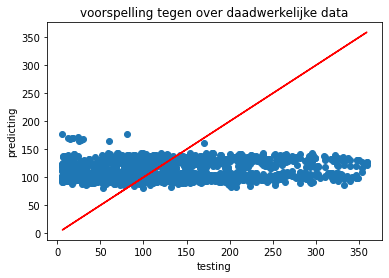

In [42]:
# model plotten en lineare regressie er in verwerken
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_test)
ax.plot(y_test, y_test, color='red')
ax.set_xlabel('testing')
ax.set_ylabel('predicting')
ax.set_title('voorspelling tegen over daadwerkelijke data')

In [43]:
from collections import OrderedDict
new_data = OrderedDict([
    ('stm_km_van_mld',50),
    ('stm_prioriteit',5),
    ('Dag_van_jaar',214),
    ('Jaar',2020),
    ('Minuut_van_dag', 800)
])

new_data = pd.Series(new_data).values.reshape(1,-1)

linear_reg_model.predict(new_data)

array([[137.95103769]])